In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import tensorflow as tf
from tensorflow import keras
import numpy as np
from torch.utils.data import DataLoader, RandomSampler

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [5]:
def split_data(x_data, y_data, num_clients=5):
    client_data = []
    num_items_per_client = x_data.shape[0] // num_clients
    for i in range(num_clients):
        start = i * num_items_per_client
        end = start + num_items_per_client
        client_x = x_data[start:end]
        client_y = y_data[start:end]
        if client_x.size > 0 and client_y.size > 0:
            client_data.append((client_x, client_y))
    return client_data

In [6]:
def federated_sgd(clients, model_constructor, x_test, y_test, rounds=10, epochs=1):
    global_model = model_constructor()
    accuracy_history = []

    for _ in range(rounds):
        for client_x, client_y in clients:
            local_model = model_constructor()
            local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            local_model.fit(client_x, client_y, epochs=epochs, verbose=0)

            # Update global model with local gradients
            global_model_weights = global_model.get_weights()
            local_model_weights = local_model.get_weights()
            new_weights = [global_weight - (global_weight - local_weight) for global_weight, local_weight in zip(global_model_weights, local_model_weights)]
            global_model.set_weights(new_weights)

        # Evaluate global model after each round
        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        accuracy_history.append(accuracy)

    return global_model, accuracy_history

In [7]:
clients = split_data(x_train, y_train)
global_model, accuracy_history = federated_sgd(clients, create_model, x_test, y_test)

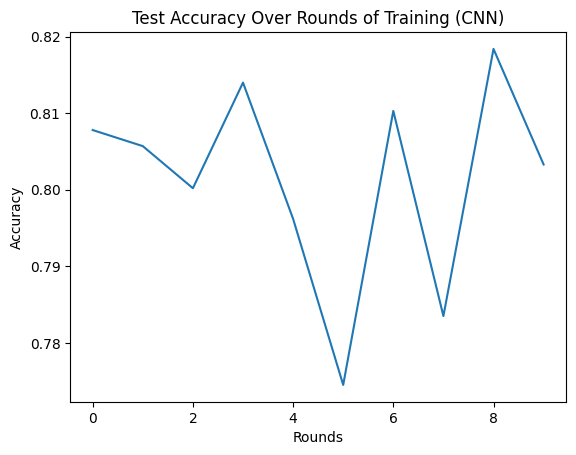

Final test accuracy: 0.8033000230789185


In [8]:
plt.plot(accuracy_history)
plt.title('Test Accuracy Over Rounds of Training (CNN)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()
print(f"Final test accuracy: {accuracy_history[-1]}")